# Model Evaluation
## Goals
1. Load all trained models (Ridge, XGBoost baseline, XGBoost tuned, Neural Network, Ensemble)
2. Evaluate on Test Set (previously unseen data)
3. Compare all models side-by-side
4. Test set performance analysis

In [1]:
# Imports
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import torch
import torch.nn as nn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_validate

In [2]:
# Constants
CLEANED_FILE_PATH: str = "../../data/cleaned/regression"
MODELS_SAVE_PATH: str = "../../models/regression"
FIGURES_SAVE_PATH: str = "../../figures"

RANDOM_STATE: int = 42

## Load Test Set and Models

In [3]:
# Load Test Set
output_dir = Path(CLEANED_FILE_PATH)

X_test = pl.read_csv(output_dir / "X_test_engineered.csv")
y_test_log = pl.read_csv(output_dir / "y_test_log.csv")["annual_salary_log"]
y_test_orig = pl.read_csv(output_dir / "y_test.csv")["annual_salary"]

print("Test Set Loaded:")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_test_log shape: {y_test_log.shape}")
print(f"  y_test_orig shape: {y_test_orig.shape}")

# Convert to numpy for sklearn models
X_test_np = X_test.to_numpy()
y_test_log_np = y_test_log.to_numpy()
y_test_orig_np = y_test_orig.to_numpy()

Test Set Loaded:
  X_test shape: (3383, 54)
  y_test_log shape: (3383,)
  y_test_orig shape: (3383,)


In [4]:
# Load Models
models_dir = Path(MODELS_SAVE_PATH)

print("Loading trained models...\n")

# Traditional ML Models
ridge_model = joblib.load(models_dir / "ridge_model.pkl")
print("✓ Ridge Regression loaded")

xgb_baseline = joblib.load(models_dir / "xgb_model.pkl")
print("✓ XGBoost Baseline loaded")

xgb_tuned = joblib.load(models_dir / "xgb_tuned.pkl")
print("✓ XGBoost Tuned loaded")

ensemble_model = joblib.load(models_dir / "stacking_model.pkl")
print("✓ Stacking Ensemble loaded")


# First, define the architecture (must match training)
class MLPRegressor(nn.Module):
    def __init__(self, input_dim):
        super(MLPRegressor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        return self.network(x)


# Load NN model
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
nn_model = MLPRegressor(X_test.shape[1]).to(device)
nn_model.load_state_dict(torch.load(models_dir / "mlp_model_best.pth"))
nn_model.eval()
print(f"✓ Neural Network loaded (device: {device})")

print("\n✓ All models loaded successfully\n")

Loading trained models...

✓ Ridge Regression loaded
✓ XGBoost Baseline loaded
✓ XGBoost Tuned loaded
✓ Stacking Ensemble loaded
✓ Neural Network loaded (device: mps)

✓ All models loaded successfully



## Evaluate Models

In [5]:
# Evaluation Functions
def inverse_transform_salary(log_salary_pred: np.ndarray) -> np.ndarray:
    """Convert log-transformed salaries back to original scale"""
    return np.expm1(log_salary_pred)


def evaluate_sklearn_model(
    model, X: np.ndarray, y_true_log: np.ndarray, model_name: str
) -> dict:
    """Evaluate sklearn models on test set"""
    y_pred_log = model.predict(X)

    # Log scale metrics
    rmse_log = np.sqrt(mean_squared_error(y_true_log, y_pred_log))
    mae_log = mean_absolute_error(y_true_log, y_pred_log)
    r2_log = r2_score(y_true_log, y_pred_log)

    # Original scale metrics
    y_true_orig = inverse_transform_salary(y_true_log)
    y_pred_orig = inverse_transform_salary(y_pred_log)

    rmse_orig = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
    mae_orig = mean_absolute_error(y_true_orig, y_pred_orig)
    r2_orig = r2_score(y_true_orig, y_pred_orig)

    print(f"--- {model_name} ---")
    print(f"RMSE (log): {rmse_log:.4f}")
    print(f"MAE (log):  {mae_log:.4f}")
    print(f"R² (log):   {r2_log:.4f}")
    print(f"RMSE ($):   ${rmse_orig:,.0f}")
    print(f"MAE ($):    ${mae_orig:,.0f}")
    print(f"R² ($):     {r2_orig:.4f}\n")

    return {
        "model_name": model_name,
        "rmse_log": rmse_log,
        "mae_log": mae_log,
        "r2_log": r2_log,
        "rmse_orig": rmse_orig,
        "mae_orig": mae_orig,
        "r2_orig": r2_orig,
        "y_pred_orig": y_pred_orig,
        "y_pred_log": y_pred_log,
    }


def evaluate_nn_model(
    model, X: np.ndarray, y_true_log: np.ndarray, model_name: str
) -> dict:
    """Evaluate PyTorch neural network on test set"""
    X_tensor = torch.tensor(X.astype(np.float32)).to(device)

    model.eval()
    with torch.no_grad():
        y_pred_log = model(X_tensor).cpu().numpy().flatten()

    # Log scale metrics
    rmse_log = np.sqrt(mean_squared_error(y_true_log, y_pred_log))
    mae_log = mean_absolute_error(y_true_log, y_pred_log)
    r2_log = r2_score(y_true_log, y_pred_log)

    # Original scale metrics
    y_true_orig = inverse_transform_salary(y_true_log)
    y_pred_orig = inverse_transform_salary(y_pred_log)

    rmse_orig = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
    mae_orig = mean_absolute_error(y_true_orig, y_pred_orig)
    r2_orig = r2_score(y_true_orig, y_pred_orig)

    print(f"--- {model_name} ---")
    print(f"RMSE (log): {rmse_log:.4f}")
    print(f"MAE (log):  {mae_log:.4f}")
    print(f"R² (log):   {r2_log:.4f}")
    print(f"RMSE ($):   ${rmse_orig:,.0f}")
    print(f"MAE ($):    ${mae_orig:,.0f}")
    print(f"R² ($):     {r2_orig:.4f}\n")

    return {
        "model_name": model_name,
        "rmse_log": rmse_log,
        "mae_log": mae_log,
        "r2_log": r2_log,
        "rmse_orig": rmse_orig,
        "mae_orig": mae_orig,
        "r2_orig": r2_orig,
        "y_pred_orig": y_pred_orig,
        "y_pred_log": y_pred_log,
    }

In [6]:
# Evaluate Models on Test Set
print("Evaluating all models on test set:\n")

# Evaluate each model
ridge_results = evaluate_sklearn_model(
    ridge_model, X_test_np, y_test_log_np, "Ridge Regression"
)
xgb_baseline_results = evaluate_sklearn_model(
    xgb_baseline, X_test_np, y_test_log_np, "XGBoost Baseline"
)
xgb_tuned_results = evaluate_sklearn_model(
    xgb_tuned, X_test_np, y_test_log_np, "XGBoost Tuned"
)
ensemble_results = evaluate_sklearn_model(
    ensemble_model, X_test_np, y_test_log_np, "Stacking Ensemble"
)
nn_results = evaluate_nn_model(nn_model, X_test_np, y_test_log_np, "Neural Network")

Evaluating all models on test set:

--- Ridge Regression ---
RMSE (log): 0.4045
MAE (log):  0.3109
R² (log):   0.4234
RMSE ($):   $49,486
MAE ($):    $30,759
R² ($):     0.3395

--- XGBoost Baseline ---
RMSE (log): 0.3910
MAE (log):  0.3017
R² (log):   0.4613
RMSE ($):   $47,767
MAE ($):    $29,876
R² ($):     0.3846

--- XGBoost Tuned ---
RMSE (log): 0.3876
MAE (log):  0.2986
R² (log):   0.4706
RMSE ($):   $47,576
MAE ($):    $29,592
R² ($):     0.3895

--- Stacking Ensemble ---
RMSE (log): 0.3899
MAE (log):  0.3003
R² (log):   0.4643
RMSE ($):   $47,768
MAE ($):    $29,745
R² ($):     0.3846



/Users/Effy/Documents/Projects/ML_Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/Users/Effy/Documents/Projects/ML_Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


--- Neural Network ---
RMSE (log): 0.3957
MAE (log):  0.3052
R² (log):   0.4483
RMSE ($):   $48,170
MAE ($):    $30,193
R² ($):     0.3742



## Comparison
### Individual Model Comparison

In [7]:
# Comparison Table
comparison_data = {
    "Model": [
        "Ridge Regression",
        "XGBoost Baseline",
        "XGBoost Tuned",
        "Stacking Ensemble",
        "Neural Network",
    ],
    "RMSE (log)": [
        ridge_results["rmse_log"],
        xgb_baseline_results["rmse_log"],
        xgb_tuned_results["rmse_log"],
        ensemble_results["rmse_log"],
        nn_results["rmse_log"],
    ],
    "MAE (log)": [
        ridge_results["mae_log"],
        xgb_baseline_results["mae_log"],
        xgb_tuned_results["mae_log"],
        ensemble_results["mae_log"],
        nn_results["mae_log"],
    ],
    "R² (log)": [
        ridge_results["r2_log"],
        xgb_baseline_results["r2_log"],
        xgb_tuned_results["r2_log"],
        ensemble_results["r2_log"],
        nn_results["r2_log"],
    ],
    "RMSE ($)": [
        ridge_results["rmse_orig"],
        xgb_baseline_results["rmse_orig"],
        xgb_tuned_results["rmse_orig"],
        ensemble_results["rmse_orig"],
        nn_results["rmse_orig"],
    ],
    "MAE ($)": [
        ridge_results["mae_orig"],
        xgb_baseline_results["mae_orig"],
        xgb_tuned_results["mae_orig"],
        ensemble_results["mae_orig"],
        nn_results["mae_orig"],
    ],
    "R² ($)": [
        ridge_results["r2_orig"],
        xgb_baseline_results["r2_orig"],
        xgb_tuned_results["r2_orig"],
        ensemble_results["r2_orig"],
        nn_results["r2_orig"],
    ],
}

comparison_df = pl.DataFrame(comparison_data).sort("RMSE ($)")
comparison_df

Model,RMSE (log),MAE (log),R² (log),RMSE ($),MAE ($),R² ($)
str,f64,f64,f64,f64,f64,f64
"""XGBoost Tuned""",0.387625,0.298624,0.470572,47575.623394,29592.334352,0.389526
"""XGBoost Baseline""",0.391015,0.30173,0.461271,47766.72577,29876.452583,0.384612
"""Stacking Ensemble""",0.389925,0.30032,0.46427,47767.531412,29744.908832,0.384591
"""Neural Network""",0.395688,0.305218,0.448316,48169.95987,30192.83377,0.374178
"""Ridge Regression""",0.404533,0.310907,0.423376,49486.425041,30758.648175,0.339504


In [8]:
# Find best model
best_model_idx = comparison_df["RMSE ($)"].arg_min()
best_model_name = comparison_df["Model"][best_model_idx]
best_rmse = comparison_df["RMSE ($)"][best_model_idx]

print(f"Best Model: {best_model_name}")
print(f"Test RMSE: ${best_rmse:,.0f}")

Best Model: XGBoost Tuned
Test RMSE: $47,576


### Individual Models vs Ensemble Models

In [9]:
individual_models = comparison_df.filter(
    pl.col("Model").is_in(
        ["Ridge Regression", "XGBoost Baseline", "XGBoost Tuned", "Neural Network"]
    )
)
ensemble_models = comparison_df.filter(pl.col("Model").is_in(["Stacking Ensemble"]))

print(
    "Individual Models Average RMSE:", f"${individual_models['RMSE ($)'].mean():,.0f}"
)
print("Ensemble Models Average RMSE:", f"${ensemble_models['RMSE ($)'].mean():,.0f}")

ensemble_improvement = (
    ensemble_models["RMSE ($)"].mean() - individual_models["RMSE ($)"].mean()
)
print(
    f"\nEnsemble Improvement: ${ensemble_improvement:,.0f} ({ensemble_improvement / individual_models['RMSE ($)'].mean() * 100:.1f}%)"
)

Individual Models Average RMSE: $48,250
Ensemble Models Average RMSE: $47,768

Ensemble Improvement: $-482 (-1.0%)


In our case, ensemble models seem to provide negligible benefit. This could be due to:
1. **Low Model Diversity**: All models hit similar performance ceiling (~$50k RMSE)
2. **Data Limitations**: Limited complementary errors to correct
3. **Performance Ceiling**: Performance ceiling due to data limitations

## Visualization

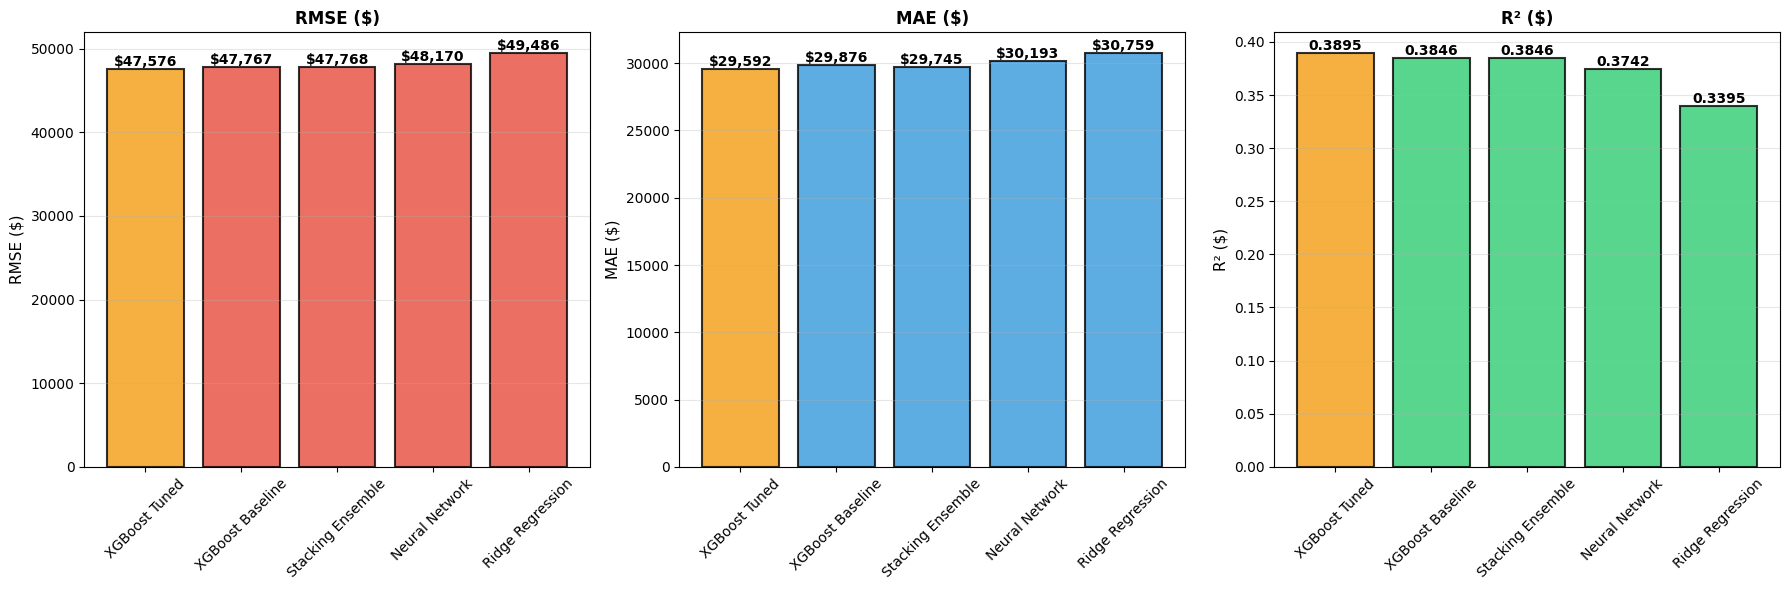

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

metrics = [
    ("RMSE ($)", "RMSE ($)", "#e74c3c"),
    ("MAE ($)", "MAE ($)", "#3498db"),
    ("R² ($)", "R² ($)", "#2ecc71"),
]

for (metric_label, col_name, color), ax in zip(metrics, axes):
    values = comparison_df[col_name].to_list()
    models = comparison_df["Model"].to_list()

    # Color the best one differently
    colors = [color if i != best_model_idx else "#f39c12" for i in range(len(models))]

    bars = ax.bar(
        models, values, color=colors, alpha=0.8, edgecolor="black", linewidth=1.5
    )

    # Add value labels
    for bar, val in zip(bars, values):
        height = bar.get_height()
        label = (
            f"${val:,.0f}"
            if "MAE" in metric_label or "RMSE" in metric_label
            else f"{val:.4f}"
        )
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            label,
            ha="center",
            va="bottom",
            fontweight="bold",
            fontsize=10,
        )

    ax.set_title(metric_label, fontsize=12, fontweight="bold")
    ax.set_ylabel(metric_label, fontsize=11)
    ax.tick_params(axis="x", rotation=45)
    ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig(
    Path(FIGURES_SAVE_PATH) / "final_model_comparison.png", dpi=300, bbox_inches="tight"
)
plt.show()

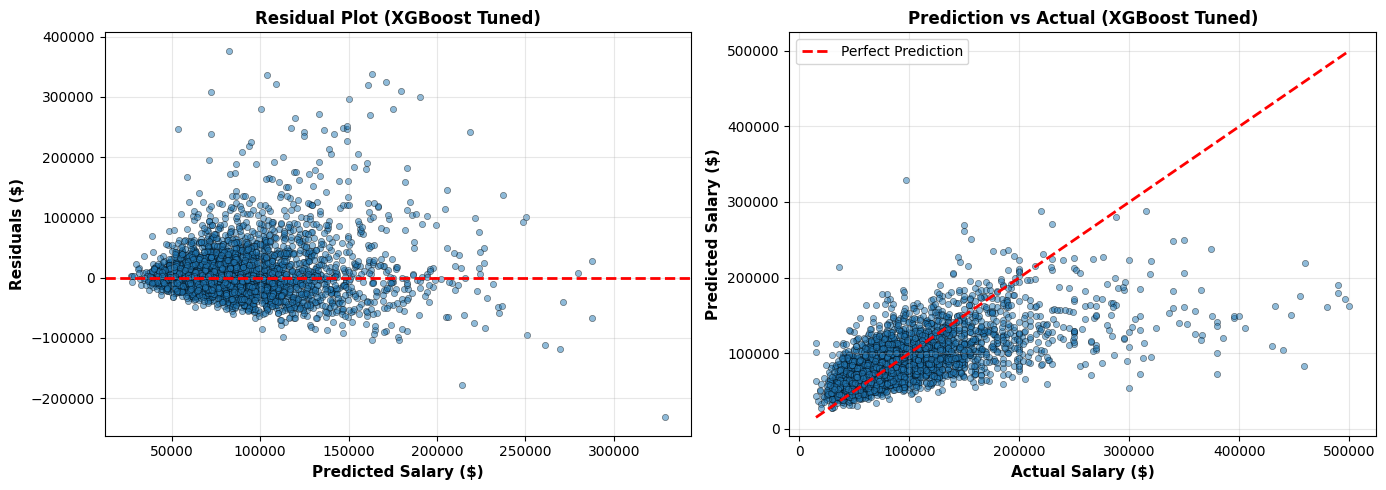

Residual Analysis (XGBoost Tuned):
  Mean Residual: $8,198
  Std Residual: $46,864
  95% CI: $91,853
  Min Residual: $-232,131
  Max Residual: $376,502


In [11]:
if best_model_name == "Ridge Regression":
    best_y_pred_orig = ridge_results["y_pred_orig"]
elif best_model_name == "XGBoost Baseline":
    best_y_pred_orig = xgb_baseline_results["y_pred_orig"]
elif best_model_name == "XGBoost Tuned":
    best_y_pred_orig = xgb_tuned_results["y_pred_orig"]
elif best_model_name == "Stacking Ensemble":
    best_y_pred_orig = ensemble_results["y_pred_orig"]
else:  # Neural Network
    best_y_pred_orig = nn_results["y_pred_orig"]

residuals = y_test_orig_np - best_y_pred_orig

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residual plot
axes[0].scatter(
    best_y_pred_orig, residuals, alpha=0.5, s=20, edgecolors="black", linewidth=0.5
)
axes[0].axhline(0, color="red", linestyle="--", linewidth=2)
axes[0].set_xlabel("Predicted Salary ($)", fontsize=11, fontweight="bold")
axes[0].set_ylabel("Residuals ($)", fontsize=11, fontweight="bold")
axes[0].set_title(f"Residual Plot ({best_model_name})", fontsize=12, fontweight="bold")
axes[0].grid(alpha=0.3)

# Prediction vs Actual
axes[1].scatter(
    y_test_orig_np, best_y_pred_orig, alpha=0.5, s=20, edgecolors="black", linewidth=0.5
)
axes[1].plot(
    [y_test_orig_np.min(), y_test_orig_np.max()],
    [y_test_orig_np.min(), y_test_orig_np.max()],
    "r--",
    linewidth=2,
    label="Perfect Prediction",
)
axes[1].set_xlabel("Actual Salary ($)", fontsize=11, fontweight="bold")
axes[1].set_ylabel("Predicted Salary ($)", fontsize=11, fontweight="bold")
axes[1].set_title(
    f"Prediction vs Actual ({best_model_name})", fontsize=12, fontweight="bold"
)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(
    Path(FIGURES_SAVE_PATH) / "best_model_residuals.png", dpi=300, bbox_inches="tight"
)
plt.show()

print(f"Residual Analysis ({best_model_name}):")
print(f"  Mean Residual: ${residuals.mean():,.0f}")
print(f"  Std Residual: ${residuals.std():,.0f}")
print(f"  95% CI: ${1.96 * residuals.std():,.0f}")
print(f"  Min Residual: ${residuals.min():,.0f}")
print(f"  Max Residual: ${residuals.max():,.0f}")

Error Distribution by Salary Range:



Salary Band,Count,Mean Error,Median Error,RMSE
str,i64,f64,f64,f64
"""Low (<$50k)""",510,22133.355599,17947.943359,28267.107329
"""Lower-Mid ($50-75k)""",956,16133.289649,11840.730469,21844.364526
"""Mid ($75-100k)""",719,18018.006389,14440.433594,25154.079871
"""Upper-Mid ($100-150k)""",703,28165.04588,27133.210938,33721.212422
"""High (>$150k)""",494,81593.88709,67905.011719,104799.638877


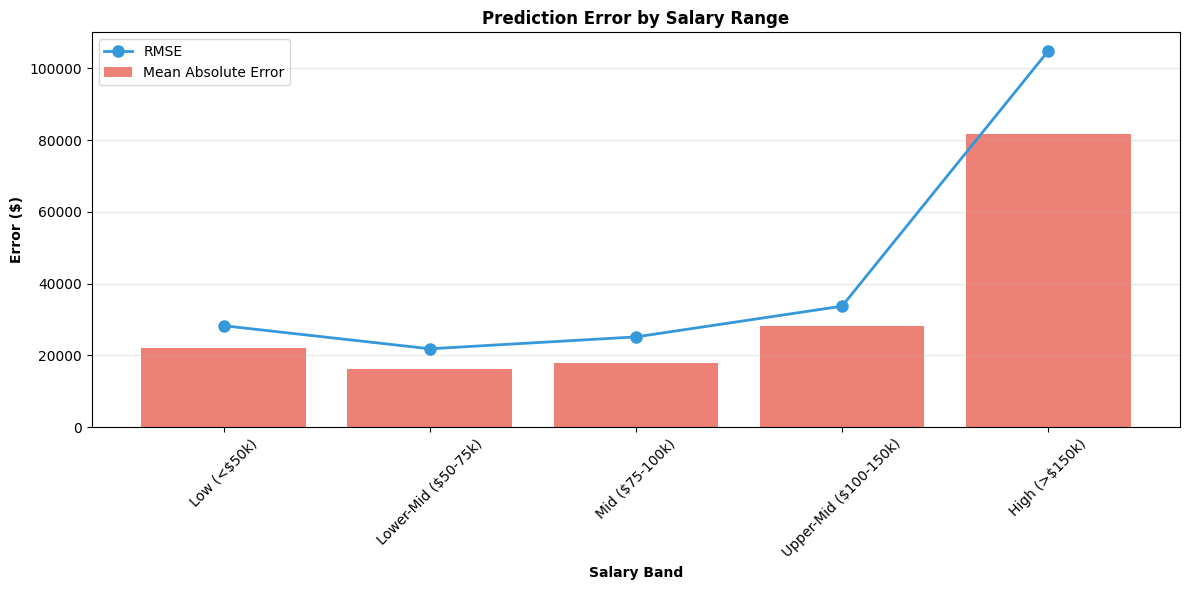


Key Findings:
  Highest error in: High (>$150k)
  RMSE: $104,800
  → Model struggles most with this salary range


In [12]:
# %% Error Distribution Analysis
print("Error Distribution by Salary Range:\n")

# Define salary bands
salary_bands = [
    (15000, 50000, "Low (<$50k)"),
    (50000, 75000, "Lower-Mid ($50-75k)"),
    (75000, 100000, "Mid ($75-100k)"),
    (100000, 150000, "Upper-Mid ($100-150k)"),
    (150000, 500000, "High (>$150k)"),
]

# Use best model predictions
errors_by_band = []

for low, high, label in salary_bands:
    mask = (y_test_orig_np >= low) & (y_test_orig_np < high)
    if mask.sum() > 0:
        band_actuals = y_test_orig_np[mask]
        band_preds = best_y_pred_orig[mask]
        band_errors = np.abs(band_actuals - band_preds)

        errors_by_band.append(
            {
                "Salary Band": label,
                "Count": mask.sum(),
                "Mean Error": band_errors.mean(),
                "Median Error": np.median(band_errors),
                "RMSE": np.sqrt(mean_squared_error(band_actuals, band_preds)),
            }
        )

errors_df = pl.DataFrame(errors_by_band)
display(errors_df)

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(
    errors_df["Salary Band"],
    errors_df["Mean Error"],
    color="#e74c3c",
    alpha=0.7,
    label="Mean Absolute Error",
)
ax.plot(
    errors_df["Salary Band"],
    errors_df["RMSE"],
    color="#3498db",
    marker="o",
    linewidth=2,
    markersize=8,
    label="RMSE",
)

ax.set_xlabel("Salary Band", fontweight="bold")
ax.set_ylabel("Error ($)", fontweight="bold")
ax.set_title("Prediction Error by Salary Range", fontweight="bold")
ax.legend()
ax.tick_params(axis="x", rotation=45)
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig(Path(FIGURES_SAVE_PATH) / "error_by_salary_band.png", dpi=300)
plt.show()

print("\nKey Findings:")
worst_band = errors_df.sort("RMSE", descending=True)[0]
print(f"  Highest error in: {worst_band['Salary Band'][0]}")
print(f"  RMSE: ${worst_band['RMSE'][0]:,.0f}")
print(
    f"  → Model struggles most with {'high earners' if 'High' in worst_band['Salary Band'] else 'this salary range'}"
)

## Cross-Validation

In [ ]:
X_train = pl.read_csv(output_dir / "X_train_engineered.csv")
y_train_log = pl.read_csv(output_dir / "Y_train_log.csv")

scoring = {
    "rmse": "neg_root_mean_squared_error",
    "mae": "neg_mean_absolute_error",
    "r2": "r2_score",
}

models_for_cv = {
    "Ridge Regression": ridge_model,
    "XGBoost Baseline": xgb_baseline,
    "XGBoost Tuned": xgb_tuned,
    "Stacking Ensemble": ensemble_model,
}

cv_results_dict = {}

print("5-Fold Cross-Validation on Training Set:\n")

for model_name, model in models_for_cv.items():
    # Perform 5-fold cross-validation on training set
    cv_scores = cross_validate(
        model,
        X_train,
        y_train_log,
        cv=5,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
        return_train_score=True,
    )

    # Convert back to positive RMSE
    train_rmse_cv = np.sqrt(-cv_scores["train_score"])
    val_rmse_cv = np.sqrt(-cv_scores["test_score"])

    cv_results_dict[model_name] = {
        "train_rmse_mean": train_rmse_cv.mean(),
        "train_rmse_std": train_rmse_cv.std(),
        "val_rmse_mean": val_rmse_cv.mean(),
        "val_rmse_std": val_rmse_cv.std(),
    }

    print(f"{model_name}:")
    print(f"  Train RMSE (CV): {train_rmse_cv.mean():.4f} ± {train_rmse_cv.std():.4f}")
    print(f"  Val RMSE (CV):   {val_rmse_cv.mean():.4f} ± {val_rmse_cv.std():.4f}")
    print(f"  Overfitting Gap: {(train_rmse_cv.mean() - val_rmse_cv.mean()):.4f}\n")

## Summary

In [ ]:
median_salary = np.median(y_test_orig_np)
mean_salary = np.mean(y_test_orig_np)
salary_range = np.max(y_test_orig_np) - np.min(y_test_orig_np)

print("Test Set Salary Statistics:")
print(f"  Median: ${median_salary:,.0f}")
print(f"  Mean: ${mean_salary:,.0f}")
print(f"  Range: ${salary_range:,.0f}")

best_rmse_orig = comparison_df["RMSE ($)"][best_model_idx]
best_mae_orig = comparison_df["MAE ($)"][best_model_idx]

print(f"\n{best_model_name} Performance:")
print(
    f"  RMSE: ${best_rmse_orig:,.0f} ({best_rmse_orig / median_salary * 100:.1f}% of median)"
)
print(
    f"  MAE: ${best_mae_orig:,.0f} ({best_mae_orig / median_salary * 100:.1f}% of median)"
)
print(f"  Average prediction is off by ~${best_mae_orig:,.0f}")